# Disease Norm

In this example, we'll be writing an application to extract *mentions of* diseases from Pubmed abstracts, using annotations from the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial, which has 5 parts, walks through the process of constructing a model to classify _candidate_ disease mentions as either true (i.e., that it is truly a mention of a disease) or false.

# Loading Candidates + Annotations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass

Disease = candidate_subclass('Disease', ['disease'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Training Candidates').one()
print len(train)
dev = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Development Candidates').one()
print len(dev)
test = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Test Candidates').one()
print len(test)

28087
27896
29646


In [3]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

L_gold_train = label_manager.load(session, train, "CDR Training Label Set")
print L_gold_train.shape
L_gold_dev = label_manager.load(session, dev, "CDR Development Label Set")
print L_gold_dev.shape
L_gold_test = label_manager.load(session, test, "CDR Test Label Set")
print L_gold_test.shape

(28087, 1)
(27896, 1)
(29646, 1)


# Process / Load Features

In [34]:
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()

Process:

In [ ]:
%time F_train = feature_manager.create(session, train, 'Train Features')

In [ ]:
%time F_dev = feature_manager.update(session, dev, 'Train Features', False)

In [ ]:
%time F_test = feature_manager.update(session, test, 'Train Features', False)

Or, load if already processed:

In [35]:
%time F_train = feature_manager.load(session, train, 'Train Features')

NoResultFound: No row was found for one()

In [33]:
%time F_dev = feature_manager.load(session, dev, 'Train Features')

NameError: name 'feature_manager' is not defined

In [4]:
import cPickle

def save_pkl_matrix(X, db_name, matrix_name, root_dir=''):
    with open('%s%s_%s.data.pkl' % (root_dir, db_name, matrix_name), 'wb') as f:
        cPickle.dump(X.data, f)
    with open('%s%s_%s.indices.pkl' % (root_dir, db_name, matrix_name), 'wb') as f:
        cPickle.dump(X.indices, f)
    with open('%s%s_%s.indptr.pkl' % (root_dir, db_name, matrix_name), 'wb') as f:
        cPickle.dump(X.indptr, f)

In [ ]:
save_pkl_matrix(F_train, 'disease_norm', 'F_train')
save_pkl_matrix(F_dev, 'disease_norm', 'F_dev')
save_pkl_matrix(F_test, 'disease_norm', 'F_test')

# Load dictionaries

### Load the MESH ID -> CID mapping

In [5]:
from cPickle import load
MESH_to_CID = load(open('MESH_to_CID.pkl', 'rb'))
diseases    = load(open('diseases.pkl', 'rb'))

In [6]:
mesh_to_terms = defaultdict(set)
for term, mid in diseases.iteritems():
    mesh_to_terms[mid].add(term)

### Create a canonical dictionary (CD)

In [7]:
from utils import CanonicalDictionary
cd = CanonicalDictionary(MESH_to_CID)

### Add MESH to CD

In [8]:
# Load MESH
from utils import load_mesh_raw
mesh_entries = load_mesh_raw('data/desc2016.xml')

Loaded 27885 entries


In [9]:
# Add MESH to cd
for entry in mesh_entries:
    mid, ps, terms = entry
    paths = [[p[0]] + p[1:].split('.') for p in ps]
    for term in terms:
        cd.add_term(term, mid, tree_paths=paths)

len(cd.term_to_sids)

151006

### Add MEDIC to CD

Custom CTD diseases dictionary made from MESH category C + OMIM

In [10]:
from utils import load_MEDIC, load_mesh_raw
medic_entries, MEDIC_to_CID = load_MEDIC()

Loaded 11864 MEDIC entries


In [11]:
# Add MESH to cd
for entry in medic_entries:
    if entry.id.startswith("MESH"):
        mid = entry.id.split(":")[1]
    elif len(entry.parent_ids) > 0 and entry.parent_ids[0].startswith("MESH"):
        mid = entry.parent_ids[0].split(":")[1]
    else:
        raise KeyError(entry)
    
    paths = []
    for p in entry.tree_nums:
        x = p.split("/")[0]
        paths.append([x[0]] + x[1:].split('.'))
    
    terms = [entry.name] + entry.synonyms
    for term in terms:
        cd.add_term(term, mid, tree_paths=paths)
        
len(cd.term_to_sids)

178666

### Add UMLS to CD

This may or may not be all of the UMLS... file from Jason

In [12]:
with open('cui2mesh.tsv', 'rb') as f:
    for line in f:
        term, cui, mid = line.rstrip('\n').split('\t')
        cd.add_term(term, mid)

len(cd.term_to_sids)

801566

## TODO: Add MESH supp?  No paths though?

# Writing some multinomial LFs

# NOTE: Beware of LF rollback bug!!!

## TYPE I LF: Subsets of MESH dictionary

In [13]:
SEEN_GLOBAL = defaultdict(set)

## MESH exact match

In [14]:
POS_DEPTH = 2
NEG_DEPTH = 1
def LFG_CD_match(c, p, key_mod=None, seen_global=None, max_paths_per_sid=1):
    """
    Given a candidate c, some transformed candidate disease phrase p,
    and an optional key name modifier key_mod to be appended, return a generator
    of key, value pairs
    """
    if p in cd.term_to_sids:
        for sid in cd.term_to_sids[p]:
            cid   = cd.sid_to_cid[sid] if sid in cd.sid_to_cid else -1
            paths = cd.tree_paths[sid]
            for path in paths[:max_paths_per_sid]:
                    
                # NOTE: path may be shorter than max depth if higher up in the tree (e.g. 'cancer', 'ischemia')!
                key = "-".join(path[:POS_DEPTH]) if cid > 0 else "-".join(path[:NEG_DEPTH])
                        
                # CHECK AGAINST / ADD TO GLOBAL SEEN SET!
                # To make sure that relaxations of an LF don't overlap with each other on any given candidate
                if seen_global is None or c.id not in seen_global[key]:
                    if seen_global is not None:
                        seen_global[key].add(c.id)
                    if key_mod:
                        key += "-" + key_mod
                    yield key, cid

In [15]:
def LFG_MESH_exact(c):
    p = c.disease.get_span().lower()
    
    # GIVE US OVERLAPS!!!
    #return LFG_CD_match(c, p, seen_global=SEEN_GLOBAL)
    return LFG_CD_match(c, p)

In [16]:
%time L_train = label_manager.create(session, train, 'LF Training Labels -- ALL [small]', f=LFG_MESH_exact)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 1min 25s, sys: 16.5 s, total: 1min 41s
Wall time: 1min 29s


<28087x40 sparse matrix of type '<type 'numpy.float64'>'
	with 7687 stored elements in Compressed Sparse Row format>

In [ ]:
%time L_dev = label_manager.update(session, dev, 'LF Training Labels -- ALL [small]', False, f=LFG_MESH_exact)
L_dev

### Drop JJs

In [17]:
def drop_jjs(c):
    toks  = []
    words = c.disease.get_attrib_tokens()
    for i, tag in enumerate(c.disease.get_attrib_tokens('pos_tags')):
        if re.match(r'JJ.*', tag) is None:
            toks.append(words[i])
    return " ".join(toks).lower()

In [18]:
def LFG_MESH_exact_drop_JJs(c):
    p = drop_jjs(c)
    
    # GIVE US OVERLAPS!!!
    return LFG_CD_match(c, p, key_mod="DJ")

In [19]:
%time L_train = label_manager.update(session, train, 'LF Training Labels -- ALL [small]', True, LFG_MESH_exact_drop_JJs)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 1min 31s, sys: 16.8 s, total: 1min 48s
Wall time: 1min 35s


<28087x81 sparse matrix of type '<type 'numpy.float64'>'
	with 17096 stored elements in Compressed Sparse Row format>

In [ ]:
%time L_dev = label_manager.update(session, dev, 'LF Training Labels -- ALL [small]', False, LFG_MESH_exact_drop_JJs)
L_dev

## MESH TF-IDF cosine match

In [20]:
%%time
from entity_norm import CanonDictVectorizer

# Create a vectorizer based around this 
cd_vectorizer = CanonDictVectorizer(cd.term_to_sids, other_phrases=[])

# Vectorize the dictionary
D  = cd_vectorizer.vectorize_phrases(cd.terms)
Dt = D.T
Dt

|V| = 271512
CPU times: user 2min 22s, sys: 4 s, total: 2min 26s
Wall time: 2min 31s


In [21]:
POS_DEPTH         = 2
NEG_DEPTH         = 1
THRESH            = 0.75
max_paths_per_sid = 1

# GIVE US OVERLAPS!!!
#seen_global       = SEEN_GLOBAL
seen_global = None

def LFG_CD_cosine_match(c):
    p  = c.disease.get_span().lower()
    cx = cd_vectorizer.vectorize_phrases([p])
    m  = cx * Dt
    m  = m.tocoo()

    best_match = defaultdict(lambda : (0,None))
    for i, s in enumerate(m.data):
        if s > THRESH:
            j = m.col[i]
            t = cd.terms[j]
            for sid in cd.term_to_sids[t]:
                cid = cd.sid_to_cid[sid] if sid in cd.sid_to_cid else -1
                for path in cd.tree_paths[sid][:max_paths_per_sid]:
                    key  = "-".join(path[:POS_DEPTH]) if cid > 0 else "-".join(path[:NEG_DEPTH])
                    if s > best_match[key][0]:
                        best_match[key] = (s, cid)

    for key, x in best_match.iteritems():
        s, cid = x
        
        # CHECK AGAINST / ADD TO GLOBAL SEEN SET!
        # To make sure that relaxations of an LF don't overlap with each other on any given candidate
        if seen_global is None or c.id not in seen_global[key]:
            if seen_global is not None:
                seen_global[key].add(c.id)
            key += "-c"
            yield key, cid

In [22]:
%time L_train = label_manager.update(session, train, 'LF Training Labels -- ALL [small]', True, LFG_CD_cosine_match)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 25min 28s, sys: 3min 49s, total: 29min 18s
Wall time: 29min 1s


<28087x123 sparse matrix of type '<type 'numpy.float64'>'
	with 42539 stored elements in Compressed Sparse Row format>

In [ ]:
%time L_dev = label_manager.update(session, dev, 'LF Training Labels -- ALL [small]', False, LFG_CD_cosine_match)
L_dev

# Putting in some negative LFs

In [23]:
import re
from lf_terms import *
from snorkel.lf_helpers import get_left_tokens, get_right_tokens
from utils import *
from Disease_Tagging_Tutorial_LFs import *
chemicals = load_chemdner_dictionary()

def LF_organs(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in organs else 0      

def LF_chemical_name(c):
    phrase = " ".join(c[0].get_attrib_tokens())
    return -1 if phrase in chemicals and not phrase.isupper() else 0

def LF_bodysym(c):
    phrase = " ".join(c[0].get_attrib_tokens()).lower()
    return -1 if phrase in bodysym else 0  

def LF_protein_chemical_abbrv(c):
    '''Gene/protein/chemical name'''
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("\d+",lemma) else 0

def LF_base_pair_seq(c): 
    lemma = " ".join(c[0].get_attrib_tokens('lemmas'))
    return -1 if re.search("^[GACT]{2,}$",lemma) else 0

LFs_false = [LF_chemical_name,
             LF_organs,
             LF_bodysym,
             LF_protein_chemical_abbrv,
             LF_base_pair_seq,
             LF_too_vague,
             LF_neg_surfix,
             LF_non_common_disease,
             LF_non_disease_acronyms,
             LF_pos_in,
             LF_gene_chromosome_link,
             LF_right_window_incomplete,
             LF_negative_indicator
            ]

In [24]:
%time L_train = label_manager.update(session, train, 'LF Training Labels -- ALL [small]', True, LFs_false)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 5min 30s, sys: 19.3 s, total: 5min 50s
Wall time: 5min 35s


<28087x136 sparse matrix of type '<type 'numpy.float64'>'
	with 56469 stored elements in Compressed Sparse Row format>

In [ ]:
%time L_dev = label_manager.update(session, dev, 'LF Training Labels -- ALL [small]', False, LFs_false)
L_dev

In [ ]:
# LOAD if already computed
L_train = label_manager.load(session, train, 'LF Training Labels -- ALL 1')
L_train

# Running gen. model

In [27]:
from utils import binarize_LF_matrix, get_binarized_score
L_train_b = binarize_LF_matrix(L_train)
#L_dev_b   = binarize_LF_matrix(L_dev)

In [29]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
%time gen_model.train(L_train_b, n_iter=5000, rate=1e-3, verbose=True)

/Library/Python/2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	28087
Features:			136
Begin training for rate=0.001, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.276912
	Learning epoch = 250	Gradient mag. = 0.294585
	Learning epoch = 500	Gradient mag. = 0.297642
	Learning epoch = 750	Gradient mag. = 0.300653
	Learning epoch = 1000	Gradient mag. = 0.303619
	Learning epoch = 1250	Gradient mag. = 0.306537
	Learning epoch = 1500	Gradient mag. = 0.309407
	Learning epoch = 1750	Gradient mag. = 0.312228
	Learning epoch = 2000	Gradient mag. = 0.315001
	Learning epoch = 2250	Gradient mag. = 0.317726
	Learning epoch = 2500	Gradient mag. = 0.320401
	Learning epoch = 2750	Gradient mag. = 0.323029
	Learning epoch = 3000	Gradient mag. = 0.325609
	Learning epoch = 3250	Gradient mag. = 0.328143
	Learning epoch = 3500	Gradient mag. = 0.330631
	Learning epoch = 3750	Gradient mag. = 0.333075
	Learning epoch = 4000	Gradient mag. = 0.335475
	Learning epoch = 4250	Gradient mag. = 0.337833
	Learning epoch = 4500	Gradient mag. = 0.340151
	Le

In [30]:
yp = gen_model.predict(L_train_b)
get_binarized_score(yp, L_gold_train)

P :	0.820423758249
R :	0.610335917313
F1:	0.69995554897


In [ ]:
yp_dev = gen_model.predict(L_dev_b)
get_binarized_score(yp_dev, L_gold_dev)

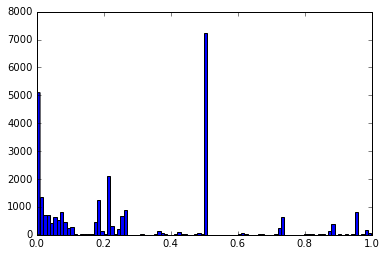

In [31]:
plt.hist(gen_model.marginals(L_train_b), bins=100)
plt.show()

In [ ]:
# Print LF stats...
from snorkel.learning import odds_to_prob
lfs = L_train.lf_stats(labels=L_gold_train, est_accs=odds_to_prob(gen_model.w))
lfs.nlargest(50, "coverage")

# Save `L_train` as pkls

In [28]:
save_pkl_matrix(L_train_b, 'disease_norm', 'L_train_2_1')

In [ ]:
save_pkl_matrix(L_dev_b, 'disease_norm', 'L_dev_small')

In [ ]:
save_pkl_matrix(L_gold_train, 'disease_norm', 'L_gold_train')

In [ ]:
save_pkl_matrix(L_gold_dev, 'disease_norm', 'L_gold_dev')

In [ ]:
save_pkl_matrix(L_gold_test, 'disease_norm', 'L_gold_test')

# TODO: RERUN ABOVE!!!

# Error analysis

Current ideas:
* Take out 'F' category? [6]
* Take out supplemental entries [2]
* Don't emit all tree paths?  **This essentially gives many more votes if it has multiple tree paths!!!** [3]

In [ ]:
from random import shuffle
N_train = L_gold_train.shape[0]

fps = []
fns = []
for i in range(N_train):
    if yp[i] > 0 and L_gold_train[i] < 0:
        fps.append(i)
    elif yp[i] < 0 and L_gold_train[i] > 0:
        fns.append(i)

shuffle(fps)
shuffle(fns)

print len(fps)
print len(fns)

In [ ]:
from snorkel.viewer import SentenceNgramViewer
fn_cands = [L_train.get_candidate(i) for i in fns[:100]]
svn      = SentenceNgramViewer(fn_cands, session)
svn

In [ ]:
c = svn.get_selected()
c

In [ ]:
c.disease.get_attrib_tokens('pos_tags')

In [ ]:
from snorkel.models import Label
session.query(Label).filter(Label.candidate == c).all()

In [ ]:
from snorkel.learning.gen_learning import odds_to_prob
i = L_train.get_row_index(c)

for j in L_train.getrow(i).nonzero()[1]:
    print L_train.get_key(j), odds_to_prob(gen_model.w[j]), int(L_train[i,j])

In [ ]:
cd.cid_to_sid[1419]

In [ ]:
mesh_to_terms[cd.cid_to_sid[1419]]

In [ ]:
cd.term_to_sids['depression']

In [ ]:
for key, cid in LFG_MESH_exact(c):
    print key, cid

In [ ]:
for key, cid in LFG_CD_cosine_match(c):
    print key, cid

In [ ]:
mt = 0.5
m  = m.tocoo()
for i, s in enumerate(m.data):
    if s > mt:
        j = m.col[i]
        t = cd.terms[j]
        print t, s
        for sid in cd.term_to_sids[t]:
            cid = cd.sid_to_cid[sid] if sid in cd.sid_to_cid else -1
            print "\t", sid, cid
            for path in cd.tree_paths[sid]:
                key  = "-".join(path[:POS_DEPTH]) if cid > 0 else "-".join(path[:NEG_DEPTH])
                print "\t\t", key

In [ ]:
for j in m.nonzero()[1]:
    t = cd.terms[j]
    print t, cd.term_to_sids[t]

In [ ]:
cd.sid_to_cid['C566870']

In [ ]:
[cd.sid_to_cid[sid] for sid in cd.term_to_sids['toxicity']]

In [ ]:
cd.cid_to_sid[5593]

# TODO:

* _DONE: Re-write the cosine matcher_
* _DONE: Switch to MESH 2016_
* _DONE: Add in supplementary records!_
* **Try labeling in cascading if-then fashion...?**

# Training Discriminative model

In [ ]:
from snorkel.learning import LogReg

train_marginals = gen_model.marginals(L_train_b)

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-3, mu=1e-6)

In [ ]:
yp = disc_model.predict(F_train)
get_binarized_score(yp, L_gold_train)

In [ ]:
yp = disc_model.predict(F_dev, b=0.5)
get_binarized_score(yp, L_gold_dev)

In [ ]:
plt.hist(disc_model.marginals(F_dev))
plt.show()

In [ ]:
from snorkel.learning.gen_learning import odds_to_prob
plt.hist(odds_to_prob(gen_model.w))

In [ ]:
L_train.lf_stats(labels=L_gold_train, est_accs=odds_to_prob(gen_model.w))

# What is going on??

In [ ]:
F_dev

In [ ]:
L_gold_dev

In [ ]:
all([F_dev.get_candidate(i) == L_dev.get_candidate(i) for i in range(F_dev.shape[0])])

In [ ]:
L_gold_train

In [ ]:
len(dev)

# Hard filtering

In [ ]:
# Try overriding with any exact matches...
ype = np.zeros(L_gold_train.shape[0])
for i,c in enumerate(dev):
    if i % 5000 == 0:
        print i
    pos = 0
    neg = 0
    for lf_name, label in LFG_MESH_exact(c):
        if label > 0:
            pos += 1
        else:
            neg += 1
    
    for lf_name, label in LFG_MESH_exact_drop_JJs(c):
        if label > 0:
            pos += 1
        else:
            neg += 1
    
    if neg > 0 and pos == 0:
        ype[i] = -1
    elif pos > 0 and neg == 0:
        ype[i] = 1
    else:
        ype[i] = yp[i]

In [ ]:
get_binarized_score(ype, L_gold_dev)

# Now, getting CIDs in simple heuristic way

In [ ]:
N = L_gold_train.shape[0]

In [ ]:
pp_idxs = [i for i in range(N) if yp[i] == 1 and L_gold_train[i] > 0]
pp_idxs[:5]

In [ ]:
i = 32
for j in L_train.getrow(i).nonzero()[1]:
    print L_train.get_key(j), gen_model.w[j], L_train[i,j]

In [ ]:
i = 53
for j in L_train.getrow(i).nonzero()[1]:
    print L_train.get_key(j), gen_model.w[j], L_train[i,j]

In [ ]:
L_gold_train[53,0]

In [ ]:
print L_train.get_key(558)
print gen_model.w[558]
print L_train[18,558]

In [ ]:
correct   = 0
predicted = 0
total     = 0
for i in range(N):
    if L_gold_train[i,0] > 0:
        total += 1
    
    if yp[i] > 0:
        predicted += 1
        
        max_w = 0.0
        cid   = -1
        for j in L_train.getrow(i).nonzero()[1]:
            if gen_model.w[j] > max_w:
                max_w = gen_model.w[j]
                cid   = L_train[i,j]
        
        if cid == L_gold_train[i,0]:
            correct += 1

prec   = correct / float(predicted)
recall = correct / float(total)

print "P:\t", prec
print "R:\t", recall
print "F1:\t", (2*prec*recall) / (prec+recall)

In [ ]:
correct   = 0
predicted = 0
total     = 0
for i in range(N):
    if L_gold_train[i,0] > 0:
        total += 1
        
    max_w = 0.0
    cid   = -1
    for j in L_train.getrow(i).nonzero()[1]:
        if gen_model.w[j] > max_w:
            max_w = gen_model.w[j]
            cid   = L_train[i,j]
        
    if cid > 0:
        predicted += 1  
        if cid == L_gold_train[i,0]:
            correct += 1

prec   = correct / float(predicted)
recall = correct / float(total)

print "P:\t", prec
print "R:\t", recall
print "F1:\t", (2*prec*recall) / (prec+recall)

# ETC

# Different cut levels:

Note: G = gen model on training set, D = disc. model on test set

* Pos: 1, Neg: 1, Pos-cosine: 1, Neg-cosine: 1, Thresh-cosine: 0.75 = 56 F1 G / 63 F1 D
* TODO...
* Pos: 3, Neg: 3, Pos-cosine: 3, Neg-cosine: 3, Thresh-cosine: 0.75 = 61 F1 G / 68 F1 D
* Pos: 3, Neg: 3, Pos-cosine: 3, Neg-cosine: 3, Thresh-cosine: [0.5, 0.75] = 63 F1 G / 65 F1 D
* Pos: 4, Neg: 4, Pos-cosine: 4, Neg-cosine: 4, Thresh-cosine: 0.75 = 60 F1 G / 64 F1 D

### Adding in drop_JJs + NEG LFs:

* Pos: 2, Neg: 2, Pos-cosine: 2, Neg-cosine: 2, Thresh-cosine: 0.75 = 69 F1 G / 71 F1 D
* Pos: 3, Neg: 3, Pos-cosine: 3, Neg-cosine: 3, Thresh-cosine: 0.75 = 70 F1 G / 73 F1 D


#### Note: we're not yet dealing with acronyms!!!

In [ ]:
hf = np.ones(L_train_b.shape[0])

In [ ]:
for i in range(L_train_b.shape[0]):
    

In [ ]:
L_train_b.getrow(0)

In [ ]:
L_train_b.sum(1).shape

In [ ]:
from snorkel.utils import sparse_abs
sparse_abs(L_train_b).sum(1).shape

In [ ]:
hf = np.where(L_train_b.sum(1) == sparse_abs(L_train_b).sum(1), np.sign(L_train_b.sum(1)), 0)

In [ ]:
hf.shape

In [ ]:
L_gold_train_b = np.sign(L_gold_train.todense())

In [ ]:
L_gold_train_b

In [ ]:
L_gold_train_b.T.dot(hf)

In [ ]:
hf.sum

In [ ]:
L_train_b_sum = L_train_b.sum(1)
L_train_b_abs_sum = sparse_abs(L_train_b).sum(1)
L_train_b_sum_abs = sparse_abs(L_train_b.sum(1))

In [ ]:
L_train_b

In [ ]:
correct = 0
wrong   = 0
for i in range(L_train_b.shape[0]):
    if L_train_b_sum[i] < 0 and L_train_b_sum_abs[i] == L_train_b_abs_sum[i]:
        if L_gold_train[i] < 0:
            correct += 1
        else:
            wrong += 1
            
print correct
print wrong
print correct / float(correct + wrong)

In [ ]:
N = L_train.shape[0]
N

In [ ]:
filtered = 0
correct  = 0
for i,c in enumerate(train):
    if i % 1000 == 0:
        if filtered > 0:
            print i, filtered, correct, correct / float(filtered)
        else:
            print i, filtered, correct
    
    pos = 0
    neg = 0
    for lf_name, label in LFG_MESH_exact(c):
        if label > 0:
            pos += 1
        else:
            neg += 1
    
    for lf_name, label in LFG_MESH_exact_drop_JJs(c):
        if label > 0:
            pos += 1
        else:
            neg += 1
    
    #if neg > 0 and pos == 0:
    if neg > pos:
        filtered += 1
        if L_gold_train[i] < 0:
            correct += 1

print filtered
print correct
print correct / float(filtered)

In [ ]:
filtered = 0
correct  = 0
for i,c in enumerate(train):
    if i % 1000 == 0:
        if filtered > 0:
            print i, filtered, correct, correct / float(filtered)
        else:
            print i, filtered, correct
    
    if len(c.disease.get_attrib_tokens()) == 1 and c.disease.get_span().lower() not in cd.term_to_sids:
        filtered += 1
        if L_gold_train[i] < 0:
            correct += 1

print filtered
print correct
print correct / float(filtered)

# LF STATS ANALYSIS

In [ ]:
lfs = L_train.lf_stats(labels=L_gold_train, est_accs=odds_to_prob(gen_model.w))

In [ ]:
gen_model.w

In [ ]:
BAD_LFs = [578, 627, 603, 687, 573, 579]
for i in BAD_LFs:
    gen_model.w[i] = 0.0

In [ ]:
lfs.nsmallest(50, "accuracy")

In [ ]:
for lf in lfs.iterrows():
    lf_name, s = lf
    

# ERROR ANALYSIS

In [ ]:
from random import shuffle
N_dev = L_gold_dev.shape[0]

fps = []
fns = []
for i in range(N_dev):
    if yp[i] > 0 and L_gold_dev[i] < 0:
        fps.append(i)
    elif yp[i] < 0 and L_gold_dev[i] > 0:
        fns.append(i)

shuffle(fps)
shuffle(fns)

print len(fps)
print len(fns)

from snorkel.viewer import SentenceNgramViewer
fn_cands = [F_dev.get_candidate(i) for i in fns[:100]]
svn      = SentenceNgramViewer(fn_cands, session)
svn

In [ ]:
exact_match = 0
for i in fns:
    c = F_dev.get_candidate(i)
    if c.disease.get_span() in mesh_tree:
        exact_match += 1

In [ ]:
exact_match

In [ ]:
c = svn.get_selected()

mesh_tree[c.disease.get_span()]

In [ ]:
c.disease.get_attrib_tokens('pos_tags')

In [ ]:
mesh_tree['alcohol abuse']

In [ ]:
from snorkel.models import Label

l = session.query(Label).filter(Label.candidate == c).one()
CID_to_MESH[l.value]

In [ ]:
i = F_dev.get_row_index(c)
[(F_dev.get_key(k), disc_model.w[k]) for k in F_dev.getrow(i).nonzero()[1]]

In [ ]:
F_dev.get_key(1)

* Why is Parkinson's disease not caught?

In [ ]:
from snorkel.viewer import SentenceNgramViewer
fp_cands = [F_dev.get_candidate(i) for i in fps[:100]]
sv       = SentenceNgramViewer(fp_cands, session)
sv

In [ ]:
NEG_PHRASES = [
    'stenosis',
    'further attention',
    'presence',
    'absence',
    'syndrome',
    'association',
    'strain',
    'progression'
]

NEG_END_WORDS = [
    'therapies',
    'muscles',
    'concentrations',
    'normal',
    'heart',
    'side',
    'sinus',
    'convulsants',
    'latencies',
    'findings',
    'doses',
    'remission'
]

def end_in_plural(c):
    pass

def body_part(c):
    pass

def not_exact_single_word(d):
    pass